In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import scipy as sp # type: ignore
from scipy.optimize import curve_fit # type: ignore
import matplotlib.pyplot as plt # type: ignore

import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras.models import Model # type: ignore
import keras.optimizers # type: ignore
from keras.layers import Dense, Input # type: ignore

# UNITS
ev2au = 1/27.211396132
au2ev = 27.211396132
ang2au = 1/0.529177249
au2ang = 0.529177249
au2fs = 1/41.34137333656
fs2au = 41.34137333656
au2debye = 1/0.39343
debye2au = 0.39343
au2nm = 0.052917720859
nm2au = 1/0.052917720859
au2cm1 = 2.1947463137E5
cm12au = 1/(2.1947463137E5)
au2amu = 1/1822.88848325
amu2au = 1822.88848325
thz2au = 1.0/0.029979/au2cm1

In [2]:
#La suma debe ser una suma de 32 terminos

coeff_matrix = np.zeros((32,4))
coeff_matrix[0,:] = [0,0,1,32849.58]
coeff_matrix[1,:] = [0,1,1,-17553.99]
coeff_matrix[2,:] = [1,0,1,-27625.23]
coeff_matrix[3,:] = [2,0,0,50043.09]
coeff_matrix[4,:] = [4,0,0,336.49]
coeff_matrix[5,:] = [0,1,2,-3360.94]
coeff_matrix[6,:] = [0,3,0,-64.84]
coeff_matrix[7,:] = [1,1,1,18285.40]
coeff_matrix[8,:] = [2,0,1,-7181.44]
coeff_matrix[9,:] = [0,0,4,2553.25]
coeff_matrix[10,:] = [0,2,2,-4905.39]
coeff_matrix[11,:] = [0,4,0,3505.21]
coeff_matrix[12,:] = [1,1,2,-21845.86]
coeff_matrix[13,:] = [1,3,0,-1416.44]
coeff_matrix[14,:] = [2,1,1,5596.86]
coeff_matrix[15,:] = [3,0,1,-142.39]
coeff_matrix[16,:] = [0,0,2,15623.64]
coeff_matrix[17,:] = [0,2,0,72972.84]
coeff_matrix[18,:] = [1,1,0,9857.17]
coeff_matrix[19,:] = [3,0,0,-2376.30]
coeff_matrix[20,:] = [0,2,1,-8550.95]
coeff_matrix[21,:] = [1,0,2,-4597.25]
coeff_matrix[22,:] = [1,2,0,-657.28]
coeff_matrix[23,:] = [2,1,0,1985.36]
coeff_matrix[24,:] = [0,1,3,-5546.12]
coeff_matrix[25,:] = [0,3,1,-11098.50]
coeff_matrix[26,:] = [1,0,3,-9178.03]
coeff_matrix[27,:] = [1,2,1,948.74]
coeff_matrix[28,:] = [2,0,2,-983.04]
coeff_matrix[29,:] = [2,2,0,-584.78]
coeff_matrix[30,:] = [3,1,0,1694.77]
coeff_matrix[31,:] = [0,0,3,4971.79]

def V(R1,R2,theta):
    R1e = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
    R2e = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
    alpha_1 = 1.95/ang2au #Amstrong^-1
    alpha_2 = 2.34/ang2au #Amstrong^-1
    theta_e = np.pi #Degrees

    aR1 = -alpha_1*(R1-R1e)
    aR2 = -alpha_2*(R2-R2e)

    y_1 = 1.0 - np.exp(aR1)
    y_2 = 1.0 - np.exp(aR2)
    y_3 = np.cos(theta) - np.cos(theta_e)

    suma = 0.0
    for i in range(32):
        suma = suma + (coeff_matrix[i,3]*cm12au)*(y_1**int(coeff_matrix[i,0]))*(y_2**int(coeff_matrix[i,1]))*(y_3**(coeff_matrix[i,2]))
    return(suma)

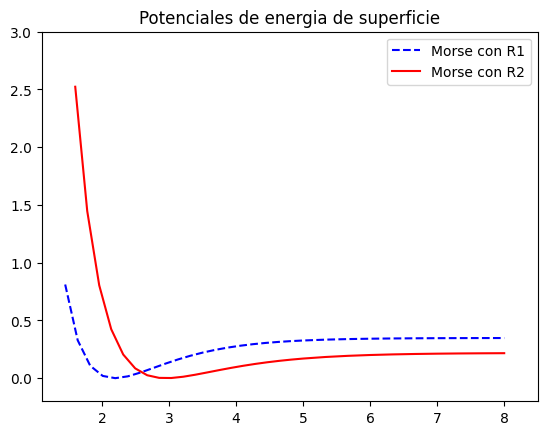

In [3]:
q1 = np.concatenate((np.linspace(1.45,5.0,20),np.linspace(5.0, 8, 10))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 10))) #Naranja
R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi

plt.plot(q1, V(R1_eq,q1,theta_eq), "--", label="Morse con R1", color="blue")
plt.plot(q2, V(q2,R2_eq,theta_eq),"-",label="Morse con R2", color="red")
plt.legend()
plt.axis([1.1,8.5,-0.2,3])
plt.title("Potenciales de energia de superficie")
plt.show()

#X = R, Y es energia

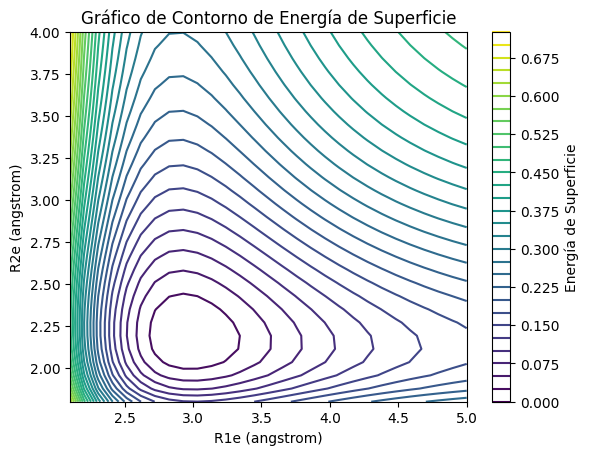

In [4]:
R1e_values = np.linspace(2.1, 5, 29)
R2e_values = np.linspace(1.8, 4, 29) 

R1e, R2e = np.meshgrid(R1e_values, R2e_values)
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi) #np.vectorize para aplicar la función a matrices

plt.contour(R1e, R2e, energia_superficie,30)
plt.colorbar(label='Energía de Superficie')

plt.xlabel('R1e (angstrom)')
plt.ylabel('R2e (angstrom)')
plt.title('Gráfico de Contorno de Energía de Superficie')
plt.show()

In [5]:
# Generacion del archivo de datos
data_set = np.zeros((len(q1)**2,3)) #Dim(729,3)
l = 0 #Inicializa en 0
for i in range(len(q1)): #R1
    for j in range(len(q2)): #R2
        data_set[l,:] = q1[i],q2[j],V(q1[i],q2[j],np.pi) #Obtenemos valores para R1, R2 y V(R1,R2)
        l = l + 1

df = pd.DataFrame(data_set)
df.to_csv('PotencialOCS_2.csv')
df.columns = ['R1','R2','V'] #Renombramos las columnas
df

,R1,R2,V
0,1.45,1.600000,4.769169
1,1.45,1.778947,4.379094
2,1.45,1.957895,4.140660
3,1.45,2.136842,3.995638
4,1.45,2.315789,3.909743
...,...,...,...
895,8.00,6.666667,0.610778
896,8.00,7.000000,0.611772
897,8.00,7.333333,0.612431
898,8.00,7.666667,0.612867


In [6]:
inputsmodel = df.drop('V', axis=1)

#Dejamos los valores de V como targets
target = df.iloc[:,-1]

print("El punto minimo del potencial es: ", min(target))
print("El punto maximo del potencial es: ", max(target))

El punto minimo del potencial es:  0.0012756203578342745
El punto maximo del potencial es:  4.769168831074749


## Morse curves fitting using Curve Fit

Las dimensiones de los parametros de los morses son:  (30, 5)


,R1,R2,V,q,D,alpha,E,Req
0,1.45,1.600000,4.769169,1.45,0.055449,1.161240,3.825052,3.007389
1,1.45,1.778947,4.379094,1.45,0.055449,1.161240,3.825052,3.007389
2,1.45,1.957895,4.140660,1.45,0.055449,1.161240,3.825052,3.007389
3,1.45,2.136842,3.995638,1.45,0.055449,1.161240,3.825052,3.007389
4,1.45,2.315789,3.909743,1.45,0.055449,1.161240,3.825052,3.007389
...,...,...,...,...,...,...,...,...
895,8.00,6.666667,0.610778,8.00,0.400981,1.241649,0.212074,2.122596
896,8.00,7.000000,0.611772,8.00,0.400981,1.241649,0.212074,2.122596
897,8.00,7.333333,0.612431,8.00,0.400981,1.241649,0.212074,2.122596
898,8.00,7.666667,0.612867,8.00,0.400981,1.241649,0.212074,2.122596


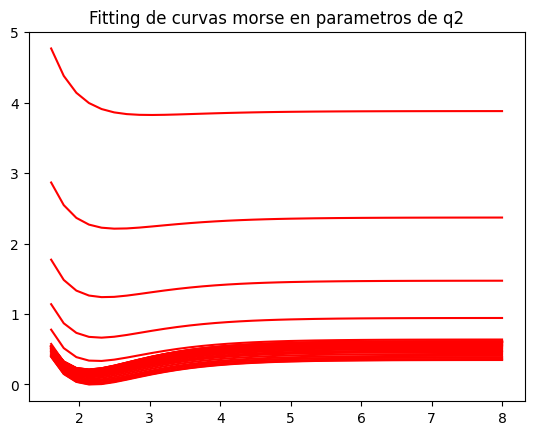

In [7]:
from scipy.optimize import curve_fit # type: ignore

def morsepotential(q, D, alpha, E0, R_eq):
    return D*(1.0 - np.exp(-alpha*(q-R_eq)))**2 + E0

xdata = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 10))) #q2, CHECK
morse_parameters = np.zeros((len(q1),5))

for i in range(len(q1)): #En este range cambio la forma de graficar
    ydata = V(q1[i],xdata,theta_eq) #Potencial segun xdata
    popt, pcov = curve_fit(morsepotential, xdata, ydata, p0=[3.49440974e-01,  1.22952512e+00, -1.73828756e-03    ,  2.18903764e+00]) #Se hace el fitting considerando un p0 inicial para el resto
    
    morse_parameters[i,0] = q1[i]
    morse_parameters[i,1:] = popt
    
    plt.title("Fitting de curvas morse en parametros de q2")
    plt.plot(xdata, morsepotential(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % 
    tuple(popt)) #Ploteo todos los popt calculados segun el ciclo for
    
    dfMorse = pd.DataFrame(morse_parameters[:]) #Creo el dataset de los valores
    dfMorse.columns = ['q','D','alpha','E','Req']
    
print("Las dimensiones de los parametros de los morses son: ",morse_parameters.shape)
dfMorse

dfaxu = pd.DataFrame(dfMorse.loc[dfMorse.index.repeat(30)].reset_index(drop=True))
dfFinal = pd.concat([df,dfaxu],axis=1)
dfFinal

## Calculate Fitting Potential

In [8]:
fit_v = []

for i, row, in dfFinal.iterrows():
    R2 = row['R2']
    D = row['D']
    alpha = row['alpha']
    E = row['E']
    Req = row['Req']
    
    potential = morsepotential(R2, D, alpha, E, Req)
    fit_v.append(potential)
    
dfFinal['VFitting'] = fit_v
dfFinal

,R1,R2,V,q,D,alpha,E,Req,VFitting
0,1.45,1.600000,4.769169,1.45,0.055449,1.161240,3.825052,3.007389,4.768990
1,1.45,1.778947,4.379094,1.45,0.055449,1.161240,3.825052,3.007389,4.380206
2,1.45,1.957895,4.140660,1.45,0.055449,1.161240,3.825052,3.007389,4.139888
3,1.45,2.136842,3.995638,1.45,0.055449,1.161240,3.825052,3.007389,3.994499
4,1.45,2.315789,3.909743,1.45,0.055449,1.161240,3.825052,3.007389,3.909280
...,...,...,...,...,...,...,...,...,...
895,8.00,6.666667,0.610778,8.00,0.400981,1.241649,0.212074,2.122596,0.610217
896,8.00,7.000000,0.611772,8.00,0.400981,1.241649,0.212074,2.122596,0.611178
897,8.00,7.333333,0.612431,8.00,0.400981,1.241649,0.212074,2.122596,0.611814
898,8.00,7.666667,0.612867,8.00,0.400981,1.241649,0.212074,2.122596,0.612234


## Loss: Fitted Potential Values + $\lambda = 0.001$


In [9]:
y_train_combined = np.column_stack([target, dfFinal['VFitting']]) #Creamos un stack para poder ingresar VFitting como parametro

def potential_loss(y_true, y_pred):
    target = y_true[:, 0:1]   # valores reales
    vfitting = y_true[:, 1:2] # valores de Morse

    mse_loss = tf.reduce_mean(tf.square(y_pred - target))
    pinn_loss = tf.reduce_mean(tf.square(y_pred - vfitting))

    numlambda = 0.5
    return mse_loss + numlambda * pinn_loss

In [10]:
#Functional API
tf.random.set_seed(5)
np.random.seed(5)
ep = 2000
pv = 0.2
loss_histories = {}
y_preds = {}
learning_rates = [0.001]

for lr in learning_rates:
    opt = keras.optimizers.Adam(learning_rate=lr)
    inputs = Input(shape=(2,))

    hidden1 = Dense(50, activation='tanh')(inputs)
    hidden2 = Dense(50, activation='tanh')(hidden1)
    hidden3 = Dense(50, activation='tanh')(hidden2)
    hidden4 = Dense(50, activation='tanh')(hidden3)
    hidden5 = Dense(50, activation='tanh')(hidden4)
    hidden6 = Dense(50, activation='tanh')(hidden5)

    output = Dense(1, activation='linear')(hidden6)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=opt, loss=potential_loss, metrics=['mse'])

    print(f"Learning rate: ", lr)
    history = model.fit(inputsmodel, y_train_combined, epochs=ep, validation_split=pv, batch_size=32)
    loss_histories[lr] = history.history
    y_preds[lr] = model.predict(inputsmodel)


Learning rate:  0.001
Epoch 1/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.4816 - mse: 0.9877 - val_loss: 0.0138 - val_mse: 0.0092
Epoch 2/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8372 - mse: 0.5581 - val_loss: 0.2319 - val_mse: 0.1546
Epoch 3/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6947 - mse: 0.4632 - val_loss: 0.0996 - val_mse: 0.0664
Epoch 4/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5917 - mse: 0.3945 - val_loss: 0.0597 - val_mse: 0.0398
Epoch 5/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4757 - mse: 0.3171 - val_loss: 0.0653 - val_mse: 0.0435
Epoch 6/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3463 - mse: 0.2308 - val_loss: 0.1748 - val_mse: 0.1166
Epoch 7/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2281 - mse: 0.1521 - val_loss: 0.0219 - val_mse: 0.0146
Epoch 8/2000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1060 - mse: 0.0707 - val_loss: 0.0093 - val_mse: 0.0062
Epoch 9/2000
23/23 ━━━━━━━━━━━━━━

# To do list:
1. Optimizer.
2. Learning-Rate.
3. Activation functions.
4. Number of layers.
5. Find a pattern for the number of neurons per layer.
6. Como mejora la regression o la predicción con PINN. 


In [11]:
y_pred = model.predict(inputsmodel) #Predecimos datos de Potencial en base a los datos de testing

datos = model.predict_on_batch(inputsmodel) #Estudiar esto
aa= datos.tolist()
lista = []
for i in range(len(aa)):
    lista.append(aa[i][0])
df1 = pd.DataFrame()
df1['predicted'] = lista

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


In [12]:
np.save('aaTrainRES_'+str(lr)+'_EPs'+str(ep)+'.npy',np.array([history.history['val_loss'],history.history['loss']]))
np.save('aaTrainPREDS_'+str(lr)+'_EPs'+str(ep)+'.npy',np.array([df['V'],lista]))

(-0.1, 5.0, 0.4, 5.0)

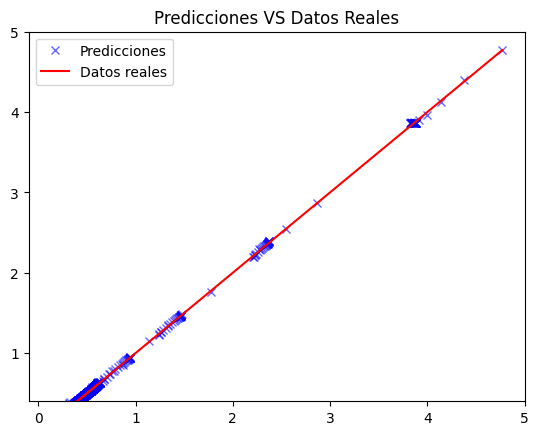

In [13]:
plt.plot(df['V'], df1['predicted'],'x', label="Predicciones", color='blue', alpha=0.6)
plt.plot(df['V'], df['V'], color='red', label='Datos reales')
plt.legend()
plt.title("Predicciones VS Datos Reales")
plt.axis([-0.1,5,0.4,5])

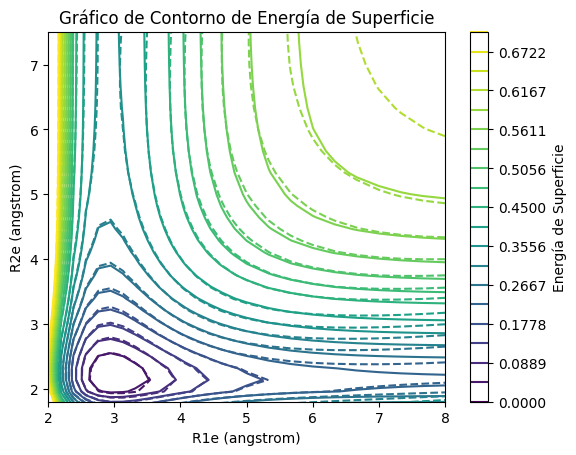

In [14]:
v128 = np.load('aaTrainPREDS_0.001_EPs2000.npy')

Ncontours = 20

R2e, R1e = np.meshgrid(q2, q1)
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi)
energia_superficie1 =  v128[1,:].reshape(len(q2),len(q2))

level_min = 0.0
level_max = 0.7
levels0 = np.concatenate((np.linspace(level_min,0.4,Ncontours-10),np.linspace(0.45,level_max,10))) #variar esto me da mas o menos niveles en la zona de mayores Rs

#plt.contour(R1e, R2e, energia_superficie,30,vmin=0.0,vmax=0.7)
plt.contour(R1e, R2e, energia_superficie,levels0,vmin=level_min,vmax=level_max)
plt.contour(R1e, R2e, energia_superficie1,levels0,vmin=level_min,vmax=level_max,linestyles='dashed')
plt.colorbar(label='Energía de Superficie')

plt.xlabel('R1e (angstrom)')
plt.ylabel('R2e (angstrom)')
plt.title('Gráfico de Contorno de Energía de Superficie')
plt.axis([2.0,8.0,1.8,7.5])
plt.show()

# Recursos de utilidad
https://wandb.ai/ayush-thakur/dl-question-bank/reports/Input-Keras-Layer-Explanation-With-Code-Samples--VmlldzoyMDIzMDU#:~:text=a%20certain%20way.-,What%20Is%20Dim%20In%20A%20Keras%20Layer%3F,tensor%20like%20(3%2C).



# Que son las PINNs?
$\textit{Physics Informed neural networks}$ son redes neuronales que incluyen leyes fisicas para resolver un problema fisico, en la forma de ecuaciones diferenciales parciales adicionales al problema supervisado original.
En las PINNs se combinan el efecto de adherirse a una ecuacion fisica asi como tambien los conocimientos familiares de machine learning

## Como se usa una PINN?
Hacer uso de una PINN incluye anadir un residual en terminos de perdida

## Ecuacion de Burgers
Consideramos la ecuacion de Burgers como ejemplo. En una dimension, la ecuacion de Burgers junto con la condicion de frontera de Dirichlet es:

\begin{split}
  u_t + uu_x - (0.001/\pi)u_{xx}=0, \\
  x \in [-1,1],t\in [0,1], \\
  u(0,x)=-\sin(\pi x), \\
  u(t,-1)=u(t,1)=0
\end{split}

Definimos $f(t,x)$ como:
$$f:= u_t+u_x-(0.01/\pi)u_{xx} $$

Luego se aproxima $u(x,t)$ con una red neuronal profunda. Los parametros compartidos entre $u(t,x)$ y $f(t,x)$ se pueden aprender minimizando la perdida de error de minimos cuadrados:

\begin{split}
    MSE=MSE_u+MSE_f, \\
    MSE_u = {1\over{N_u}}\sum_{i=1}^{N_u}{|u(t_{iu},x_{iu})-u_i|^2}, \\
    MSE_f={1\over{N_f}}\sum_{i=1}^{N_f}{|f(t_{if},x_{if})|^2}
\end{split}

el loss $MSE_u$ corresponde al data inial y a las condiciones de frontera iniciales, mientras que $MSE_f$ refuerza la estructura impuesta por la ecuacion de Burgers en un set finito de punto de colocacion, esto actua como un termino residual.
Los puntos t,x junto con la u denotan el training data inicial y de frontera en $u(t,x)$. Los puntos t,x con f especifican los puntos de colocacion para $f(t,x)$

# WORKFLOW
La funcion morse tiene una forma $$D_O[1-\exp^{-\alpha_O(r_O -r_{eq_O})}]^2$$ para el enlace del oxigeno, y una forma $$D_S[1-\exp^{-\alpha_S(r_S -r_{eq_S})}]^2$$ para el enlace del azufre.

La forma de la ecuacion a agregar a la funcion perdida personalizada es del tipo: $$\underbrace{(\hat{y_i}-y_i)^2}_{\text{MSE}} + \underbrace{(\hat{y_i}-V(r_O,r_S))^2}_{\text{PINN MSE}}$$

Podemos hacer una interpolacion o una regresion unidimensional a una de las funciones morse
Esto es funcion morse + ruido
Morse 2-D